In [ ]:
%matplotlib inline

import numpy as np
import tensorflow as tf

from seq2seq import graph_utils
from seq2seq.inference import create_inference_graph, create_predictions_iter
from seq2seq.inference import print_translations
from seq2seq.data import data_utils
from seq2seq.training import utils as training_utils

from matplotlib import pyplot as plt
tf.logging.set_verbosity(tf.logging.DEBUG)

In [8]:
MODEL_CLASS = "AttentionSeq2Seq"
MODEL_DIR = "/Users/dennybritz/Downloads/toy"
INPUT_FILE = "/tmp/toydata/test/sources.txt"
VOCAB_SOURCE = "/tmp/toydata/train/vocab.txt"
VOCAB_TARGET = "/tmp/toydata/train/vocab.txt"

In [9]:
# Create the model graph
tf.reset_default_graph()
predictions, _, _ = create_inference_graph(
    model_class="AttentionSeq2Seq",
    model_dir=MODEL_DIR,
    input_file=INPUT_FILE,
    vocab_source=VOCAB_SOURCE,
    vocab_target=VOCAB_TARGET,
    batch_size=32)
vocab_tables = graph_utils.get_dict_from_collection("vocab_tables")
features = graph_utils.get_dict_from_collection("features")

INFO:tensorflow:==================================================
INFO:tensorflow:attention.dim=128
INFO:tensorflow:attention.score_type=bahdanau
INFO:tensorflow:embedding.dim=100
INFO:tensorflow:encoder.type=BidirectionalRNNEncoder
INFO:tensorflow:inference.beam_search.beam_width=0
INFO:tensorflow:inference.beam_search.choose_successors_fn=choose_top_k
INFO:tensorflow:inference.beam_search.score_fn=logprob_score
INFO:tensorflow:optimizer.clip_gradients=5.0
INFO:tensorflow:optimizer.learning_rate=0.0001
INFO:tensorflow:optimizer.lr_decay_rate=0.99
INFO:tensorflow:optimizer.lr_decay_steps=100
INFO:tensorflow:optimizer.lr_decay_type=
INFO:tensorflow:optimizer.lr_min_learning_rate=1e-12
INFO:tensorflow:optimizer.lr_staircase=False
INFO:tensorflow:optimizer.lr_start_decay_at=0
INFO:tensorflow:optimizer.lr_stop_decay_at=1000000000.0
INFO:tensorflow:optimizer.name=Adam
INFO:tensorflow:rnn_cell.dropout_input_keep_prob=1.0
INFO:tensorflow:rnn_cell.dropout_output_keep_prob=1.0
INFO:tensorflow:

In [10]:
# Initialize the session and restore the checkpoint
saver = tf.train.Saver()
checkpoint_path = tf.train.latest_checkpoint(MODEL_DIR)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
sess.run(tf.initialize_all_tables())

saver.restore(sess, checkpoint_path)
tf.logging.info("Restored model from %s", checkpoint_path)

INFO:tensorflow:Restored model from /Users/dennybritz/Downloads/toy/model.ckpt-1318


In [11]:
# Create an iterator of predictions with some extra information
predictions["source_tokens"] = features["source_tokens"]
predictions["source_len"] = features["source_len"]
predictions["target_words"] = vocab_tables["target_id_to_vocab"].lookup(predictions["predictions"])                        
predictions_iter = create_predictions_iter(predictions, sess)

In [12]:
# Get the next predictions
pred_ = next(predictions_iter)

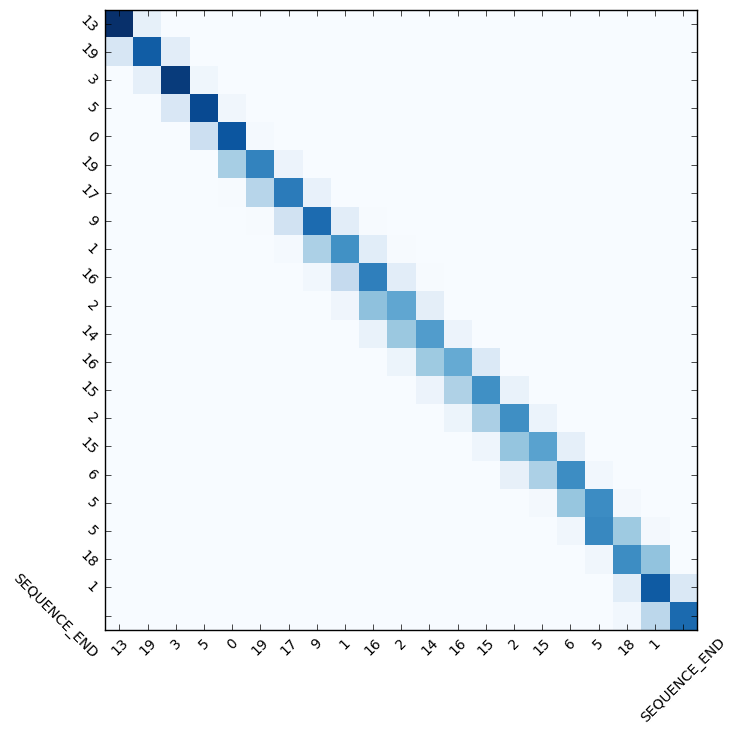

In [27]:
# Find out how long the predicted sequence is
target_words = [_.decode() for _ in pred_["target_words"]]
if "SEQUENCE_END" in target_words:
  prediction_len = target_words.index("SEQUENCE_END") + 1
else:
  prediction_len = None
target_words = target_words[:prediction_len]
  
# Get source words
source_len = pred_["source_len"]
source_words = [_.decode() for _ in pred_["source_tokens"][:source_len]]
  
# Plot
plt.figure(figsize=(8,8))
plt.imshow(pred_["attention_scores"][:prediction_len,:], interpolation='nearest', cmap=plt.cm.Blues)
plt.xticks(np.arange(source_len), source_words, rotation=45)
plt.yticks(np.arange(prediction_len), target_words, rotation=-45)
None